<a href="https://colab.research.google.com/github/michnard/art_classification_transfer_learning/blob/main/Art_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artist classification
## Given the painting, decide who drew it.

### Data
The data is based on the dataset available on Kaggle at https://www.kaggle.com/ikarus777/best-artworks-of-all-time by Icaro (Ikarus777). 

I selected 9 artists out of the total 50 available, took 100 images (for each artist) as training dataset (i.e. 900 images in total) and 20~50 images per artist, depending on availability (total ~380) as test data.

### Method

I'm gonna use different deep learning architechtures, pretrained on imagenet (as avalable from pytorch: https://pytorch.org/vision/stable/models.html) and train only the output layer.

### Transfer learning: acknowledgements!!

This exercise was inspired by Jama Hussein Mohamud & Alex Hernandez-Garcia project during Neuromatch Academy 2021 (https://deeplearning.neuromatch.io/projects/ComputerVision/transfer_learning.html). Part of the code is also (loosely) based on Sasank Chilamkurthy's "TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL" (https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [1]:
# minimal imports
import os
import numpy as np
import matplotlib.pyplot as plt

# pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

# torchvision import
import torchvision
from torchvision import datasets, models, transforms

Load data

In [2]:
# needed if you want to mount and load/save to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
path_train = "/content/gdrive/My Drive/Colab Notebooks/artists_balanced"
path_test = "/content/gdrive/My Drive/Colab Notebooks/artists_test"

In [4]:
classes = os.listdir(path_test)
classes.sort()
print(classes)

['Albrecht_Durer', 'Amedeo_Modigliani', 'Frida_Kahlo', 'Gustav_Klimt', 'Leonardo_da_Vinci', 'Pablo_Picasso', 'Sandro_Botticelli', 'Titian', 'Vincent_van_Gogh']


In [5]:
## use the same data transform for train/test. No data augmentation
data_transform=transforms.Compose([
        transforms.Resize(400), # resize shortest to 400
        transforms.CenterCrop((384, 380)), # right size for efficientnet b4
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], # standard normalization
                             [0.229, 0.224, 0.225])
])

In [6]:
### load train and test data, create loaders
data_train = datasets.ImageFolder(path_train, transform=data_transform)
data_test = datasets.ImageFolder(path_test, transform=data_transform)
train_loader = torch.utils.data.DataLoader(data_train, batch_size=4,shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=4,shuffle=True, num_workers=2)
## check the device in use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.Size([3, 384, 380])


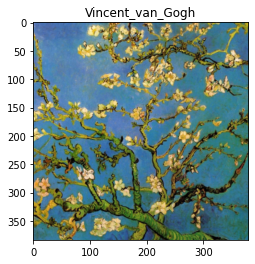

In [7]:
## imshow an image. 
img, label = data_train[-12]
print(img.shape)

plt.imshow(((img.permute(1,2,0)*torch.tensor([0.229, 0.224, 0.225]))+torch.tensor([0.485, 0.456, 0.406])))
plt.title(classes[label])
plt.show()

In [8]:
# model = models.resnet18(pretrained=True)
model = models.efficientnet_b4(pretrained=True)

### freeze layers
for param in model.parameters():
    param.requires_grad = False

### number of input features
# in_feat = model.fc.in_features # for resnet
in_feat = model.classifier[1].in_features

### create output layer - this will be trained
# model.fc = nn.Linear(in_feat, len(classes)) # for resnet
model.classifier[1] = nn.Linear(in_feat, len(classes))

### send to current device
model = model.to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth


  0%|          | 0.00/74.5M [00:00<?, ?B/s]

In [10]:
### Training setting
# use cross entropy as a loss for classification
criterion = nn.CrossEntropyLoss()
# stochastic gradient descent
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
# optimizer = optim.Adagrad(model.parameters(),lr=0.1, lr_decay=0.5)
# Decay learning rate
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5) # half LR every 4 steps
# total epochs
tot_epochs = 50

In [11]:
### Training ###

for epoch in range(tot_epochs):
  print('Epoch # = ',epoch)

  ##### train phase
  model.train() # set training mode

  # computer loss and accuracy over train data
  loss=0.
  hits=0

  # iterate over train dataloader
  for inputs,labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    # set gradient to zero
    optimizer.zero_grad()
    # turn on gradient computation
    torch.set_grad_enabled(True)
    ## forwards pass
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    ## backward pass + optimize
    loss.backward()
    optimizer.step()
    # statistics
    loss += loss.item() * inputs.size(0)
    hits += torch.sum(preds == labels.data)
  # step in the scheduler
  scheduler.step()
  ## print statistics  
  train_loss = loss / len(data_train)
  train_acc = hits.double() / len(data_train)
  print('Train Loss: {:.4f} Acc: {:.4f}'.format(train_loss, train_acc))

  ##### test phase
  model.eval() # set evaluation mode
  torch.set_grad_enabled(False) # gradient computation off

  loss = 0.0
  hits = 0

  # iterate over test images
  for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    # statistics
    loss += loss.item() * inputs.size(0)
    hits += torch.sum(preds == labels.data)

  ## print test accuracy
  test_loss = loss / len(data_test)
  test_acc = hits.double() / len(data_test)
  print('Test Loss: {:.4f} Acc: {:.4f}'.format(test_loss, test_acc))

Epoch # =  0
Train Loss: 0.0098 Acc: 0.4489
Test Loss: 0.0264 Acc: 0.6842
Epoch # =  1
Train Loss: 0.0077 Acc: 0.6511
Test Loss: 0.0173 Acc: 0.6763
Epoch # =  2
Train Loss: 0.0046 Acc: 0.6856
Test Loss: 0.0160 Acc: 0.6947
Epoch # =  3
Train Loss: 0.0064 Acc: 0.7022
Test Loss: 0.0173 Acc: 0.7184
Epoch # =  4
Train Loss: 0.0049 Acc: 0.7322
Test Loss: 0.0097 Acc: 0.7132
Epoch # =  5
Train Loss: 0.0031 Acc: 0.7378
Test Loss: 0.0188 Acc: 0.6974
Epoch # =  6
Train Loss: 0.0036 Acc: 0.7544
Test Loss: 0.0111 Acc: 0.7026
Epoch # =  7
Train Loss: 0.0051 Acc: 0.7511
Test Loss: 0.0089 Acc: 0.7211
Epoch # =  8
Train Loss: 0.0078 Acc: 0.7511
Test Loss: 0.0095 Acc: 0.7105
Epoch # =  9
Train Loss: 0.0035 Acc: 0.7678
Test Loss: 0.0162 Acc: 0.7184
Epoch # =  10
Train Loss: 0.0078 Acc: 0.7744
Test Loss: 0.0137 Acc: 0.7000
Epoch # =  11
Train Loss: 0.0052 Acc: 0.7556
Test Loss: 0.0150 Acc: 0.7105
Epoch # =  12
Train Loss: 0.0033 Acc: 0.7689
Test Loss: 0.0150 Acc: 0.7263
Epoch # =  13
Train Loss: 0.0022 Ac